**What am I predicting?**

You are predicting protein organelle localization labels for each sample. There are in total 28 different labels present in the dataset. The dataset is acquired in a highly standardized way using one imaging modality (confocal microscopy). However, the dataset comprises 27 different cell types of highly different morphology, which affect the protein patterns of the different organelles. All image samples are represented by four filters (stored as individual files), the protein of interest (green) plus three cellular landmarks: nucleus (blue), microtubules (red), endoplasmic reticulum (yellow). The green filter should hence be used to predict the label, and the other filters are used as references.

In [32]:
import os #for OS utilities
import numpy as np # for linear algebra and matrices operations
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from skimage.io import imread #For reading an image
import matplotlib.pyplot as plt # For Plotting an images
from skimage.segmentation import mark_boundaries #For drawing boundaries on the detected regions
from skimage.util import montage # To plot images in a montage style (collection of small scale )
montage_rgb = lambda x: np.stack([montage(x[:, :, :, i]) for i in range(x.shape[3])], -1)
base_dir = '../input' # Base directory
train_image_dir = os.path.join(base_dir, 'train') # path of the training images
test_image_dir = os.path.join(base_dir, 'test') # path of the test images
import gc # Garbage Collection for optimized memory allocation
gc.enable() # memory is tight
from itertools import chain #for chain interations of label
from collections import Counter # This can be used to count the labels.


A dictionary to save the target ID and the name of the Proteun. This is very useful for humans. :)

In [33]:
name_label_dictionary = {
0:  "Nucleoplasm", 
1:  "Nuclear membrane",   
2:  "Nucleoli",   
3:  "Nucleoli fibrillar center" ,  
4:  "Nuclear speckles"   ,
5:  "Nuclear bodies"   ,
6:  "Endoplasmic reticulum",   
7:  "Golgi apparatus"   ,
8:  "Peroxisomes"   ,
9:  "Endosomes"   ,
10:  "Lysosomes"   ,
11:  "Intermediate filaments",   
12:  "Actin filaments"   ,
13:  "Focal adhesion sites",   
14:  "Microtubules"   ,
15:  "Microtubule ends",   
16:  "Cytokinetic bridge",   
17:  "Mitotic spindle"   ,
18:  "Microtubule organizing center" ,  
19:  "Centrosome"   ,
20:  "Lipid droplets",   
21:  "Plasma membrane",   
22:  "Cell junctions"  , 
23:  "Mitochondria"   ,
24:  "Aggresome"   ,
25:  "Cytosol",
26:  "Cytoplasmic bodies",   
27:  "Rods & rings" 
}

In [34]:
gaussian_noise = 0.1 

# number of validation images to use
number_of_validation_images = 1000
# maximum number of training images
number_of_training_images = 15000 
#Pre-Trained Models for Transfer Learning

base_model ='VGG16' # ['VGG16', 'RESNET52', 'InceptionV3', 'Xception', 'DenseNet169', 'DenseNet121']
image_size = (299, 299) # [(224, 224), (384, 384), (512, 512), (640, 640)]
batch_size = 64 # [1, 8, 16, 24]
drop_out = 0.5
dense_count = 128
learning_rate = 1e-4
epochs = 5
rgb_flip = 1 # should rgb be flipped when rendering images


In [35]:
image_dataframe = pd.read_csv(os.path.join(base_dir,'train.csv')) #Create a Data Frame to store the images along with the labels
print(image_dataframe.shape[0], 'masks found')  #Shape of our trainig data

# Lets begin by using just the green images, :)
#image_dataframe['green_path'] = image_dataframe['Id'].map(lambda x: os.path.join(train_image_dir, '{}_green.png'.format(x)))
image_dataframe['target_list'] = image_dataframe['Target'].map(lambda x: [int(a) for a in x.split(' ')])
image_dataframe.head()


31072 masks found


,Id,Target,target_list
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0,"[16, 0]"
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0,"[7, 1, 2, 0]"
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5,[5]
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1,[1]
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18,[18]


A Counter is a dict subclass for counting hashable objects. It is an unordered collection where elements are stored as dictionary keys and their counts are stored as dictionary values.



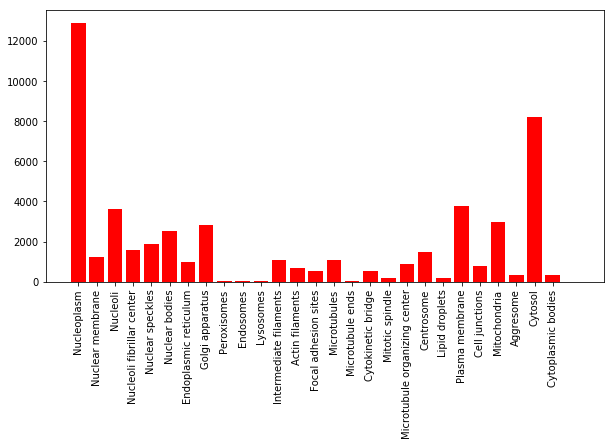

In [36]:
protein_labels = list(chain.from_iterable(image_dataframe['target_list'].values))
count_value = Counter(protein_labels)
n_keys = count_value.keys()
max_idx = max(n_keys)
fig, ax1 = plt.subplots(1,1, figsize = (10, 5))
ax1.bar(n_keys, [count_value[k] for k in n_keys],color ='red' )
ax1.set_xticks(range(max_idx))
ax1.set_xticklabels([name_label_dictionary[k] for k in range(max_idx)], rotation=90)
plt.show()


In [37]:
count_combination_dataframe = image_dataframe['Target'].value_counts()
print(count_combination_dataframe)

0             2414
25 0          1998
23            1653
25            1470
7             1163
4             1077
21            1058
2 0            996
5              983
2              808
0 21           769
7 0            668
3              654
6              622
11             601
23 0           572
19             522
14             484
5 0            479
25 21          425
19 0           395
3 0            383
25 5           350
1 0            317
18             314
25 2           301
1              271
25 4           269
25 2 0         257
12             232
              ... 
11 23 21         1
11 18            1
19 16 0 21       1
25 6 2 0         1
22 7 2           1
22 7 5           1
12 6             1
12 25 11         1
12 19 14         1
22 13 7 0        1
12 16 0          1
6 11 0           1
26 7             1
12 7 21          1
25 18 1 0        1
25 13 4          1
22 25 7 0        1
11 16            1
26 4 2           1
12 3             1
13 11 21         1
25 18 1     

In [38]:
from PIL import Image

red = np.array(Image.open("../input/test/00631ec8-bad9-11e8-b2b9-ac1f6b6435d0_red.png").convert("L"))
green = np.array(Image.open("../input/test/00631ec8-bad9-11e8-b2b9-ac1f6b6435d0_green.png").convert("L"))
blue = np.array(Image.open("../input/test/00631ec8-bad9-11e8-b2b9-ac1f6b6435d0_blue.png").convert("L"))
yellow = np.array(Image.open("../input/test/00631ec8-bad9-11e8-b2b9-ac1f6b6435d0_yellow.png").convert("L"))

demo_rgby=Image.fromarray(np.concatenate((np.expand_dims(red,axis=2),np.expand_dims(green,axis=2),np.expand_dims(blue,axis=2),np.expand_dims(yellow,axis=2)),axis=2))

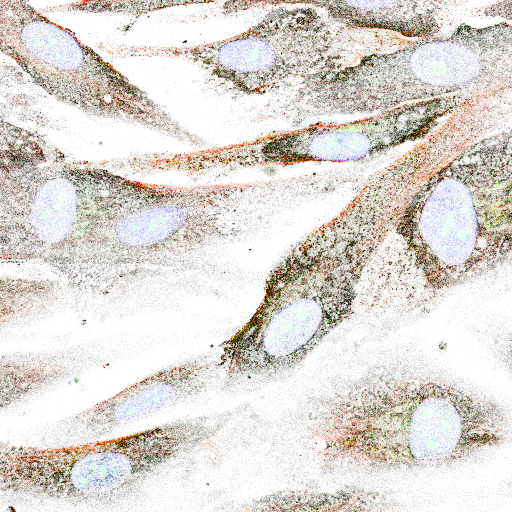

In [39]:
demo_rgby

In [ ]:
all_red =[]
all_green= []
all_blue = []
all_yellow =[]

for i in image_dataframe['Id'][0:10]:
    red = np.array(Image.open("../input/train/"+i+"_red.png").convert("L"))
    green = np.array(Image.open("../input/train/"+i+"_green.png").convert("L"))
    blue = np.array(Image.open("../input/train/"+i+"_blue.png").convert("L"))
    yellow = np.array(Image.open("../input/train/"+i+"_yellow.png").convert("L"))
    demo_rgby=Image.fromarray(np.concatenate((np.expand_dims(red,axis=2),np.expand_dims(green,axis=2),np.expand_dims(blue,axis=2),),axis=2))

demo_rgby
    
#     all_red.append(np.array(Image.open("../input/train/"+i+"_red.png").convert("L")))
#     all_green.append(np.array(Image.open("../input/train/"+i+"_green.png").convert("L")))
#     all_blue.append(np.array(Image.open("../input/train/"+i+"_blue.png").convert("L")))
#     all_yellow.append(np.array(Image.open("../input/train/"+i+"_yellow.png").convert("L")))
# print(len(all_red))
# print(len(all_green))
# print(len(all_blue))
# print(len(all_yellow))

In [ ]:
import pickle
with open('red_images.pkl','wb') as f:
    pickle.dump(all_red,f)
with open('green_images.pkl','wb') as f:
    pickle.dump(all_green,f)
with open('blue_images.pkl','wb') as f:
    pickle.dump(all_blue,f)
with open('yellow_images.pkl','wb') as f:
    pickle.dump(all_yellow,f)

In [ ]:
with open('red_images.pkl','rb') as f:
    tmp = pickle.load(f)
len(tmp)

In [ ]:
Image.fromarray(tmp[0])

In [ ]:
red = np.array(Image.open("../input/train/00070df0-bbc3-11e8-b2bc-ac1f6b6435d0_red.png").convert("L"))
Image.fromarray(red)